<a href="https://colab.research.google.com/github/marcinwolter/Tracking_student2020/blob/master/Fit_with_errors_stereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Example of fit with stereo layers performed in few steps:**

**IMPORTANT: fit for just ONE track**

1.   Perform a fit in x-z projection followed by a robust fit dropping one hit at maximum
2.   Repeat the same for y-z projection
3.   Find the distance from the stereo hits to the fitted line - drop the stereo hits which are far from track
4.   Perform a fit in 3d using all hits  







In [1]:
import numpy as np
#from numpy import *
import pylab
from scipy.optimize import curve_fit, least_squares, leastsq
from scipy import stats

# get data
! rm -fr cool_stereo.dat
! wget  https://raw.githubusercontent.com/marcinwolter/Tracking_student2020/master/cool_stereo.dat
! cat cool_stereo.dat
fn = 'cool_stereo.dat'


z_all, y_all, yerr_all, xtype = np.loadtxt(fn,unpack=True, usecols=[0,1,2,3])

#yerr *= 1.


# select projections
#x-z - projection
z_0 = []
y_0 = []
yerr_0 = []
#y-z - projection
z_1 = []
y_1 = []
yerr_1 = []
#stereo projection u
z_2 = []
y_2 = []
yerr_2 = []
#stereo projection p
z_3 = []
y_3 = []
yerr_3 = []

# create vectors for x-z, y-z, and stereo u and stereo p projections
for k in range(len(z_all)):
  if xtype[k]==0:
    z_0.append(z_all[k])
    y_0.append(y_all[k])
    yerr_0.append(yerr_all[k])
  if xtype[k]==1:
    z_1.append(z_all[k])
    y_1.append(y_all[k])
    yerr_1.append(yerr_all[k])
  if xtype[k]==2:
    z_2.append(z_all[k])
    y_2.append(y_all[k])
    yerr_2.append(yerr_all[k])
  if xtype[k]==3:
    z_3.append(z_all[k])
    y_3.append(y_all[k])
    yerr_3.append(yerr_all[k])
  
 
#print(z_0)
#print(z_1)
#print(z_2)
#print(z_3)

--2020-07-27 10:57:39--  https://raw.githubusercontent.com/marcinwolter/Tracking_student2020/master/cool_stereo.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408 [text/plain]
Saving to: ‘cool_stereo.dat’

cool_stereo.dat     100%[===================>]     408  --.-KB/s    in 0s      

2020-07-27 10:57:39 (19.4 MB/s) - ‘cool_stereo.dat’ saved [408/408]

 0 0  0.75     0
 1 0.5  .25    0
 2 2.1  .25    0
 3 3.7  0.5    0
 4 4.2  0.75   0
 5 4.6  .25    0
 7 7.1  .5     0
 3.5 9.5  0.1  0
 6 6.6  0.1    0
 0 0  0.99     1
 1 0.5  .75    1
 2 2.1  .75    1
 3 3.7  0.9    1
 4 4.2  0.75   1
 5 4.6  .55    1
 7 7.1  .9     1
 3.5 9.5  0.3  1
 6 6.6  0.3    1
 1 0.1 0.1    2
 1 2.5  0.6    2
 1 0.1 0.1    3
 1 1.5  0.1    3
 5 5.2  0.1    2
 5 7.6  0.1    3
 


In [2]:

## FIT ##
print('Fit with f(x)=ax+b')
def fit(x,a,b): 
     return a*np.asarray(x)+b

def chi2(x,y,yerr,fit,popt):
  # Now calculate chi square 
  yexp = fit(x, *popt)
  r = (y - yexp)/yerr
  chisq = np.sum(r**2)
  df = len(x) - 2
  return chisq, df, r


Fit with f(x)=ax+b


In [3]:
def fit1d_simple(fit, x, y, yerr):

  popt,pcov=curve_fit(fit,x,y,p0=(0.0,0.0),sigma=yerr, absolute_sigma=True) 
  #The argument absolute_sigma=True is necessary. It says the values in sig are all literally the standard deviations and not 
  #just relative weights for the data points. With this option the resulting chi square can be used to determine goodness of fit.

  a=popt[0]; err_a=np.sqrt(pcov[0,0])
  b=popt[1]; err_b=np.sqrt(pcov[1,1])

  chisq, df, r = chi2(x,y,yerr,fit,popt)

  return a, b, err_a, err_b, chisq, df, r, x, y, yerr

In [4]:
def fit1d_robust(fit, x, y, yerr):
  # Hand-made robust fit - drop one single outlier

  a, b, err_a, err_b, chisq, df, r, x, y, yerr = fit1d_simple(fit, x, y, yerr)
  # check chiqq/ndf
  chisq_limit = 4. # this is an arbitrary parameter, should be tuned
  if chisq/df>chisq_limit:

    # Find outlier and remove it
    # find point with the highest abs(r)
    ii = np.where(r == np.amax(abs(r)))[0]
    #ii = ii[0] 
    x_robust = np.delete(x,ii)
    y_robust = np.delete(y,ii)
    yerr_robust = np.delete(yerr,ii)
    # repeat fit without outlier
    popt,pcov=curve_fit(fit,x_robust,y_robust,p0=(0.0,0.0),sigma=yerr_robust, absolute_sigma=True)

  a=popt[0]; err_a=np.sqrt(pcov[0,0])
  b=popt[1]; err_b=np.sqrt(pcov[1,1])

  chisq, df, r = chi2(x_robust,y_robust,yerr_robust,fit,popt)
  
  return a, b, err_a, err_b, chisq, df, r, x_robust, y_robust, yerr_robust

In [5]:
# plot fit results
def fit_plot(a, b, err_a, err_b, chisq, df, x, y, yerr):

  print(" ")
  print('a=',a,"+/-",err_a)
  print('b=',b,"+/-",err_b)
  print("chisq =",chisq,"ndf =",df)
  print("chisq/ndf =",chisq/df)
  
  popt = [a, b]
  pn = np.poly1d(popt)

  # plot data and fit
  xx = np.linspace(min(x), max(x), 500)
  pylab.plot(xx, pn(xx),'-g')
  xerr = [0]*len(yerr)

  margx = 0.2*(max(x)-min(x))
  margy = 3.*max(yerr)
  pylab.axis([min(x)-margx,max(x)+margx,min(y)-margy,max(y)+margy])
  pylab.errorbar(x, y, yerr, xerr, fmt='r.')

  # customise graph
  pylab.legend(['linear','data'])

  pylab.xlabel('x label (unit)')
  pylab.ylabel('y label (unit)')

  pylab.show()

 
a= 1.1552252302451387 +/- 0.0417028048356912
b= -0.4359688064108322 +/- 0.21750857929013975
chisq = 14.790868323938867 ndf = 6
chisq/ndf = 2.4651447206564776


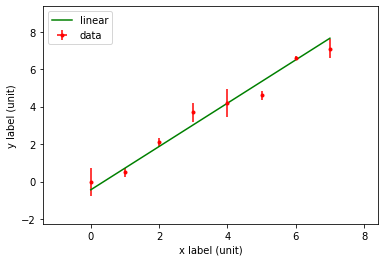

 
a= 1.1109373255575838 +/- 0.10551763463243947
b= -0.25831671892722147 +/- 0.5323752509346141
chisq = 3.0372391371203746 ndf = 6
chisq/ndf = 0.5062065228533957


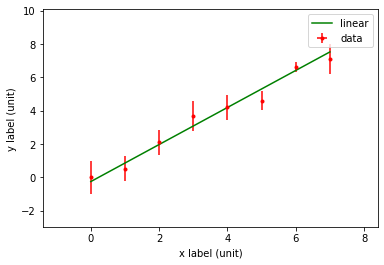

In [6]:

# Fit the x-z projection

# perform the 1d robust fit
a0, b0, err_a0, err_b0, chisq0, df0, r0, z_robust0, y_robust0, yerr_robust0 = fit1d_robust(fit, z_0, y_0, yerr_0)

# plot results
fit_plot(a0, b0, err_a0, err_b0, chisq0, df0, z_robust0, y_robust0, yerr_robust0)

# Fit the y-z projection

# perform the 1d robust fit
a1, b1, err_a1, err_b1, chisq1, df1, r1, z_robust1, y_robust1, yerr_robust1 = fit1d_robust(fit, z_1, y_1, yerr_1)

# plot results
fit_plot(a1, b1, err_a1, err_b1, chisq1, df1, z_robust1, y_robust1, yerr_robust1)

In [7]:
def distance_calc(a0, b0, a1, b1, z, y, stereo_angle):
   # calculate distance of stereo hit to track
   # track coordinates in x-y plane at z of the stereo hit
   x0 = a0*z+b0
   y0 = a1*z+b1
   #distance from track (point) to stereo strip fired (line)
   # x0* cos(alpha)+y0*sin(alpha)  + y     where alpha - stereo layer angle
   dist = x0*np.cos(stereo_angle) + y0*np.sin(stereo_angle)  - y

   #print(x0,y0)
   #print(y0*np.cos(stereo_angle), y0*np.sin(stereo_angle))
   return abs(dist)



In [8]:
# distance of stereo to track
# and find stereos whic are closer than 5*error to the track

# IMPORTANT: here we have just one track, we should make combinatorics with two tracks

# stereo 2 - angle = np.pi/4.
stereo_2 = -np.pi/4.

z_robust2=[]
y_robust2=[]
yerr_robust2=[]
for k in range(len(z_2)):
  dist = distance_calc(a0, b0, a1, b1, z_2[k], y_2[k], stereo_2)
  #print(dist,yerr_3[k])
  if dist< 5.*yerr_2[k]:
    #print("adding ",dist)
    z_robust2.append(z_2[k])
    y_robust2.append(y_2[k])
    yerr_robust2.append(yerr_2[k])

stereo_3 = np.pi/4.

z_robust3=[]
y_robust3=[]
yerr_robust3=[]
for k in range(len(z_3)):
  dist = distance_calc(a0, b0, a1, b1, z_3[k], y_3[k], stereo_3)
  #print(dist,yerr_3[k])
  if dist< 5.*yerr_3[k]:  # tolerance of 5*error is arbitrary
    #print("adding ",dist)
    z_robust3.append(z_3[k])
    y_robust3.append(y_3[k])
    yerr_robust3.append(yerr_3[k])

print("Stereo hits added with 2 orientation: ",len(z_robust2)," and with 3 orientation: ",len(z_robust3) )


Stereo hits added with 2 orientation:  2  and with 3 orientation:  2


In [9]:
def chisq3d(args):
  # total chi-square
  a0, b0, a1, b1 = args

  chisq = 0

  # x-z component
  for k in range(len(z_robust0)):
    chisq += ( (a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )**2
  # y-z component
  for k in range(len(z_robust1)):
    chisq += ( (a1*z_robust1[k]+b1 - y_robust1[k])/yerr_robust1[k] )**2

  
  # stereo fits "2"  
  for k in range(len(z_robust2)):
    chisq += ( distance_calc(a0, b0, a1, b1, z_robust2[k], y_robust2[k], stereo_2)/yerr_robust2[k] )**2
  # stereo fits "3"  
  for k in range(len(z_robust3)):
    chisq += ( distance_calc(a0, b0, a1, b1, z_robust3[k], y_robust3[k], stereo_3)/yerr_robust3[k] )**2
  
  return chisq  


In [10]:
def chisq3d_nostereo(args):
  # total chi-square but with no stereo layers
  a0, b0, a1, b1 = args

  chisq = 0

  # x-z component
  for k in range(len(z_robust0)):
    chisq += ( (a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )**2
  # y-z component
  for k in range(len(z_robust1)):
    chisq += ( (a1*z_robust1[k]+b1 - y_robust1[k])/yerr_robust1[k] )**2

  '''
  # stereo fits "2"  
  for k in range(len(z_robust2)):
    chisq += ( distance_calc(a0, b0, a1, b1, z_robust2[k], y_robust2[k], stereo_2)/yerr_robust2[k] )**2
  # stereo fits "3"  
  for k in range(len(z_robust3)):
    chisq += ( distance_calc(a0, b0, a1, b1, z_robust3[k], y_robust3[k], stereo_3)/yerr_robust3[k] )**2
  '''

  return chisq  


In [11]:
def chisq2d(args):
  # total chi-square for x-z projection only: so its 2d
  a0, b0 = args

  chisq = 0

  # x-z component
  for k in range(len(z_robust0)):
    chisq += ( (a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )**2
 
  
  return chisq  


In [12]:
def fun3d(args):
  # calculate a list of differences to be minimized by np.leastsq
  a0, b0, a1, b1 = args

  fun=[]

  # x-z component
  for k in range(len(z_robust0)):
    fun.append((a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )
  
  # y-z component
  for k in range(len(z_robust1)):
    fun.append( (a1*z_robust1[k]+b1 - y_robust1[k])/yerr_robust1[k] )
  
  
  # stereo fits "2"  
  for k in range(len(z_robust2)):
    fun.append( distance_calc(a0, b0, a1, b1, z_robust2[k], y_robust2[k], stereo_2)/yerr_robust2[k] )
  # stereo fits "3"  
  for k in range(len(z_robust3)):
    fun.append( distance_calc(a0, b0, a1, b1, z_robust3[k], y_robust3[k], stereo_3)/yerr_robust3[k] )
  
  
  return fun  


In [13]:
def fun2d(args):
  # calculate a list of differences to be minimized by np.leastsq
  a0, b0, a1, b1 = args

  fun=[]

  # x-z component
  for k in range(len(z_robust0)):
    fun.append((a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )
  

  
  return fun  


In [14]:
def fun2d_nostereo(args):
  # calculate a list of differences to be minimized by np.leastsq
  a0, b0, a1, b1 = args

  fun=[]

  # x-z component
  for k in range(len(z_robust0)):
    fun.append((a0*z_robust0[k]+b0 - y_robust0[k])/yerr_robust0[k] )
  
  # y-z component
  for k in range(len(z_robust1)):
    fun.append( (a1*z_robust1[k]+b1 - y_robust1[k])/yerr_robust1[k] )
  
  
  
  return fun  


In [15]:
# fit 3d track

par0 = [0., 0., 0., 0.]
#fit using least_squares and print results
result = least_squares(fun=chisq3d, x0 = par0, verbose=1, max_nfev=2000)
print(result.x)


`ftol` termination condition is satisfied.
Function evaluations 382, initial cost 6.9019e+07, final cost 7.3932e+02, first-order optimality 1.33e+00.
[ 1.08277927 -0.01231473  1.09869596 -0.15942537]


In [16]:
#Fit 3d track
# fit with leastsq and print results
result, cov, infodict, errmsg, success = leastsq(fun3d, x0 = par0, full_output=1)

print(result)
print(cov)

# Calculate the errors

# From documentation:
#    cov_x : ndarray
#        Uses the fjac and ipvt optional outputs to construct an
#        estimate of the jacobian around the solution. None if a
#        singular matrix encountered (indicates very flat curvature in
#        some direction).  This matrix must be multiplied by the
#        residual variance to get the covariance of the
#        parameter estimates -- see curve_fit.

SSR = np.nansum(np.asarray(fun3d(result)) ** 2)
dof = len(fun3d(result)) - len(par0)
MSE = SSR / dof
RMSE = np.sqrt(MSE)
print('SSR = ', SSR)
print('degree of freedom = ', dof)
print('estimated mean square error = ', MSE)
print('estimated root mean square error = ', RMSE)

errors = np.sqrt(np.diagonal(cov)) * RMSE


print("Fitted parameters:")
print("a0 = ",result[0]," +- ",errors[0],"  b0 = ",result[1]," +- ",errors[1])
print("a1 = ",result[2]," +- ",errors[2],"  b1 = ",result[3]," +- ",errors[3])

[ 1.08277726 -0.01233307  1.0987617  -0.15968953]
[[ 6.49634451e-04 -2.24580198e-03 -1.56744141e-04  1.12633952e-04]
 [-2.24580198e-03  1.13665079e-02 -5.03002176e-05  1.65483395e-04]
 [-1.56744141e-04 -5.03002176e-05  1.49653149e-03 -3.69959579e-03]
 [ 1.12633952e-04  1.65483395e-04 -3.69959579e-03  1.52521086e-02]]
SSR =  38.45308790522113
degree of freedom =  16
estimated mean square error =  2.4033179940763207
estimated root mean square error =  1.5502638466004168
Fitted parameters:
a0 =  1.0827772596690397  +-  0.03951301260507241   b0 =  -0.012333068621503586  +-  0.16527956030915594
a1 =  1.098761703198562  +-  0.05997200223089675   b1 =  -0.15968953034203595  +-  0.19145669775072874
